<a href="https://colab.research.google.com/github/kolikaran1992/Neural-Networks/blob/main/optimization_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In all the methods below, it is assumed that gradients have already been calculated, from either of the following methods
1. whole training data
2. mini batch
3. single instance

In [1]:
import torch
import typing
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import numpy as np
import functools
sns.set()

In [2]:
class OptimizerTemplate:

    def __init__(self, params: list, lr: float):
        self.params = list(params)
        self.lr = lr

    def zero_grad(self):
        ## Set gradients of all parameters to zero
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_() # For second-order optimizers important
                p.grad.zero_()

    @torch.no_grad()
    def step(self):
        ## Apply update step to all parameters
        for p in self.params:
            if p.grad is None: # We skip parameters without any gradients
                continue
            self.update_param(p)

    def update_param(self, p):
        # To be implemented in optimizer-specific classes
        raise NotImplementedError

# SGD

In [3]:
class SGD(OptimizerTemplate):

    def __init__(self, params, lr):
        super().__init__(params, lr)

    def update_param(self, p):
        p_update = -self.lr * p.grad
        p.add_(p_update) # In-place update => saves memory and does not create computation graph

In [4]:
def loss_curve(a: torch.Tensor) -> torch.Tensor:

    # return x**2

    return torch.where(
        (-1<a) & (a <1), a**2,
        torch.where((-4<a) & (a <-1), 0,
            torch.where(a < -4, (a+6)**4 -16, a )
                    )
                )

def plot_loss_curve(
    xlim: typing.Tuple[float, float],
    num_points: int = 100,
    figsize: typing.Tuple = (10, 7),
    ax = None
    ) -> None:
    x = torch.linspace(*xlim, num_points, dtype=torch.float32)
    y = loss_curve(x)
    x, y = x.detach().numpy(), y.detach().numpy()

    if ax is None:
        # print(zz.min())
        fig, ax = plt.subplots(1,1, figsize=figsize)

    ax.plot(x, y, ls='-', color='black', label='loss')
    ax.legend()
    # plt.legend()
    ax.set_ylabel('loss = f(x)')
    ax.set_xlabel('x')
    return ax

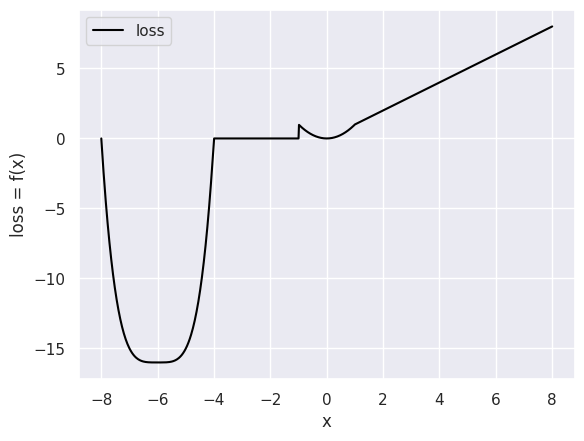

In [5]:
_ = plot_loss_curve((-8,8), num_points=1000, figsize=(5,4), ax=plt.subplots(1,1)[1])
plt.show()

In [6]:
def find_minima(
    optimizer: OptimizerTemplate,
    init: float = 2,
    num_iters: int = 100
    ) -> typing.Tuple[np.array, np.array]:

    points = []
    losses = []

    wts = nn.Parameter(data=torch.FloatTensor([init]), requires_grad=True)
    opt = optimizer([wts])
    all_data = []

    # print(wts, init)

    for _ in range(0, num_iters):
        loss = loss_curve(*wts)
        all_data.append(torch.cat([wts.data.detach(), loss.unsqueeze(dim=0).detach()], dim=0))

        # points.append(wts.detach().numpy())
        # losses.append(loss.detach())

        opt.zero_grad()
        loss.backward()
        opt.step()
        # print(wts.data)

    # points = np.stack(points, axis=0)
    # losses = torch.stack(losses, dim=0).numpy()
    all_data = torch.stack(all_data, dim=0).numpy()

    return all_data

In [7]:
# [1,2,3][-1:]

In [8]:
# find_minima(lambda p: SGD(params=p, lr=12), init=5, num_iters=20)

In [9]:
def plot_iterates_and_loss(
    init: float,
    optmizer: typing.Callable,
    num_iters: int = 30,
    figsize: typing.Tuple[int, int] = (7,5),
    ax = None,
    max_points = None,
    xlim = None,
    ylim = None
    ) -> None:
    data = find_minima(optmizer, init=init, num_iters=num_iters)

    # print(data)

    xstep = (data[:, 0].max() - data[:, 0].min())/2
    ystep = (data[:, 1].max() - data[:, 1].min())/2

    if num_iters < max_points or max_points is None:
        step = 1
    else:
        step =  num_iters//max_points

    idxs = np.where(np.array(range(num_iters)) % step == 0, True, False)
    last_true = idxs.copy()
    last_true[-1] = True
    idxs = idxs | last_true
    if not xlim:
        ax = plot_loss_curve(
            (data[:, 0].min() - xstep, data[:, 0].max() + xstep),
            num_points=200, figsize=figsize, ax=ax)
    else:
        ax = plot_loss_curve(
            xlim,
            num_points=200, figsize=figsize, ax=ax)


    ax.scatter([init], [loss_curve(torch.tensor(init))], color='red', marker='o', s=70, label = 'starting iterate')
    for i in range(1, len(data)+1):
        if (i - 1) % step == 0 or i == len(data):
            ax.annotate(f'{i}', data[i-1, :2], color='black')

    ax.scatter(data[idxs, 0], data[idxs, 1], marker='x', color='blue', s=50, alpha=0.5)
    ax.plot(*data[idxs, :2].T, ls='--')

    ax.scatter(data[-1:, 0], data[-1:, 1], marker='o', color='green', s=50, label = 'final iterate')


    if xlim is None:
        ax.set_xlim((data[:, 0].min() - xstep, data[:, 0].max() + xstep))
    else:
        ax.set_xlim(xlim)

    if ylim is None:
        ax.set_ylim((data[:, 1].min() - ystep, data[:, 1].max() + ystep))
    else:
        ax.set_ylim(ylim)

    ax.legend()
    # plt.show()

## EXPERIMENTS

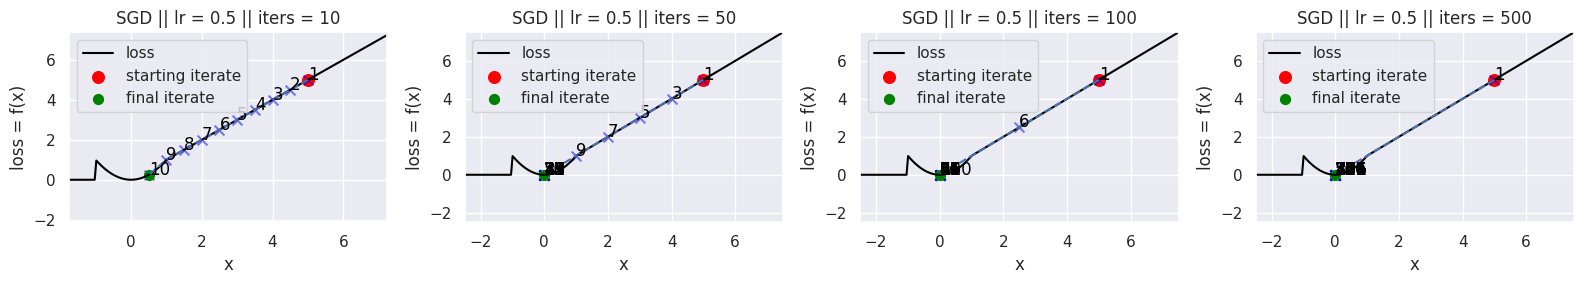

In [10]:
fig, axes = plt.subplots(1,4,figsize=(4*4,3))

for ax, iters in zip(axes, [10, 50, 100, 500]):
    lr = 0.5
    opt = SGD
    plot_iterates_and_loss(init=5, optmizer=lambda p: opt(params=p, lr=lr), num_iters=iters, max_points = 20, figsize=(4,3), ax=ax)
    ax.set_title(f'{opt.__name__} || lr = {lr} || iters = {iters}')

plt.tight_layout()
plt.show()

If the algorithm lands on a local minima, then it is permananent. Increasing the epochs does not change anything. This also means that if we start from a local minima, we wont be able to escape it.

Let's try to change the learning rate and see if it is able to escape the local minima

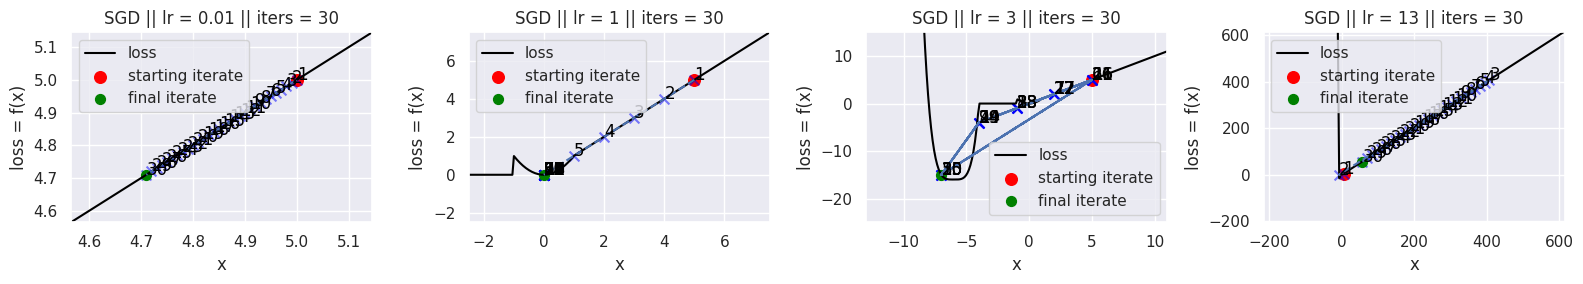

In [11]:
fig, axes = plt.subplots(1,4,figsize=(4*4,3))

for ax, lr in zip(axes, [0.01, 1, 3, 13]):
    iters = 30
    opt = SGD
    plot_iterates_and_loss(init=5, optmizer=lambda p: opt(params=p, lr=lr), num_iters=iters, max_points = 20, figsize=(4,3), ax=ax)
    ax.set_title(f'{opt.__name__} || lr = {lr} || iters = {iters}')

plt.tight_layout()
plt.show()

From the above we can conclude the following things
1. If during SGD, an iterate lands on a flat surface (gradient = 0), then it will get stuck there forever no matter the number of iterations, which seems intuitive since the update equation for SGD is $x^{t+1} = x^t - \textbf{lr}\frac{dy}{dx} \implies x^{t+1} = x^t \textbf{ if } \frac{dy}{dx} = 0$
2. Even if somehow we tune the learning rate such that an iterate is able to be near the global minima during SGD, the position of the iterate near the global minima will be very unstable. Also, as evident from the image in the right most, a large learning rate can make the algorithm land on an iterate which is very far off from even the local minima

Let's start near the global minima and observe the behaviour of the optimizer with different learning rates

<ipython-input-9-67531f0f4320>:54: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim((data[:, 1].min() - ystep, data[:, 1].max() + ystep))


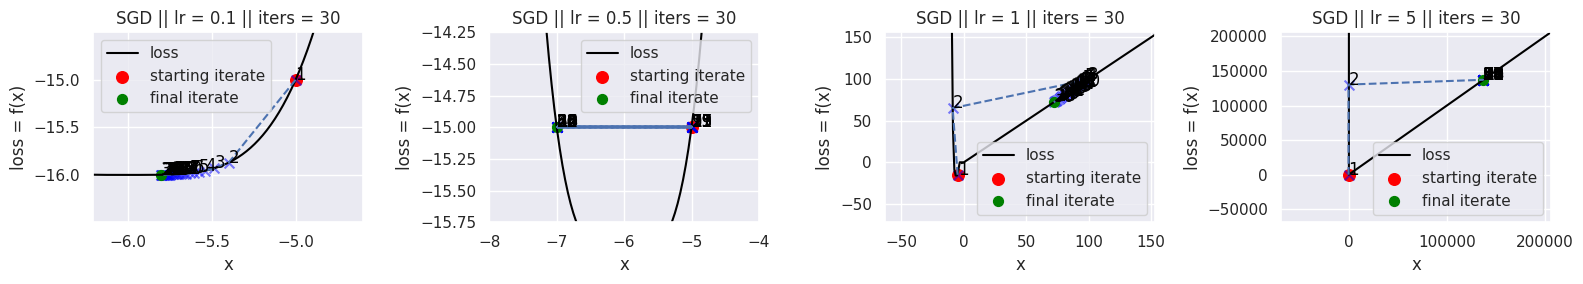

In [12]:
fig, axes = plt.subplots(1,4,figsize=(4*4,3))

for ax, lr in zip(axes, [0.1, 0.5, 1, 5]):
    iters = 30
    opt = SGD
    plot_iterates_and_loss(init=-5, optmizer=lambda p: opt(params=p, lr=lr), num_iters=iters, max_points = 20, figsize=(4,3), ax=ax)
    ax.set_title(f'{opt.__name__} || lr = {lr} || iters = {iters}')

plt.tight_layout()
plt.show()

It is evident from the second (from the left) plot, that a large enough learning rate will make the iterate bounce around the global minima even if we start near the global minima

### FINDINGS

1. slow to converge due to oscillation of the current best wts as compared to other optimizers
2. If it gets stuck on a flat surface then it becomes impossible to converge to any minima
3. very sensitive to large learning rate
4. no capacity to escape local minima

# SGD MOMENTUM

[explanation](!https://www.youtube.com/watch?v=iudXf5n_3ro&ab_channel=VisuallyExplained)

In [13]:
class SGDMomentum(OptimizerTemplate):

    def __init__(self, params, lr, momentum=0.0):
        super().__init__(params, lr)
        self.momentum = momentum # Corresponds to beta_1 in the equation above
        self.param_momentum = {p: torch.zeros_like(p.data) for p in self.params} # Dict to store m_t

    def update_param(self, p):
        self.param_momentum[p] = (1 - self.momentum) * p.grad + self.momentum * self.param_momentum[p]
        p_update = -self.lr * self.param_momentum[p]
        p.add_(p_update)

## EXPERIMENTS

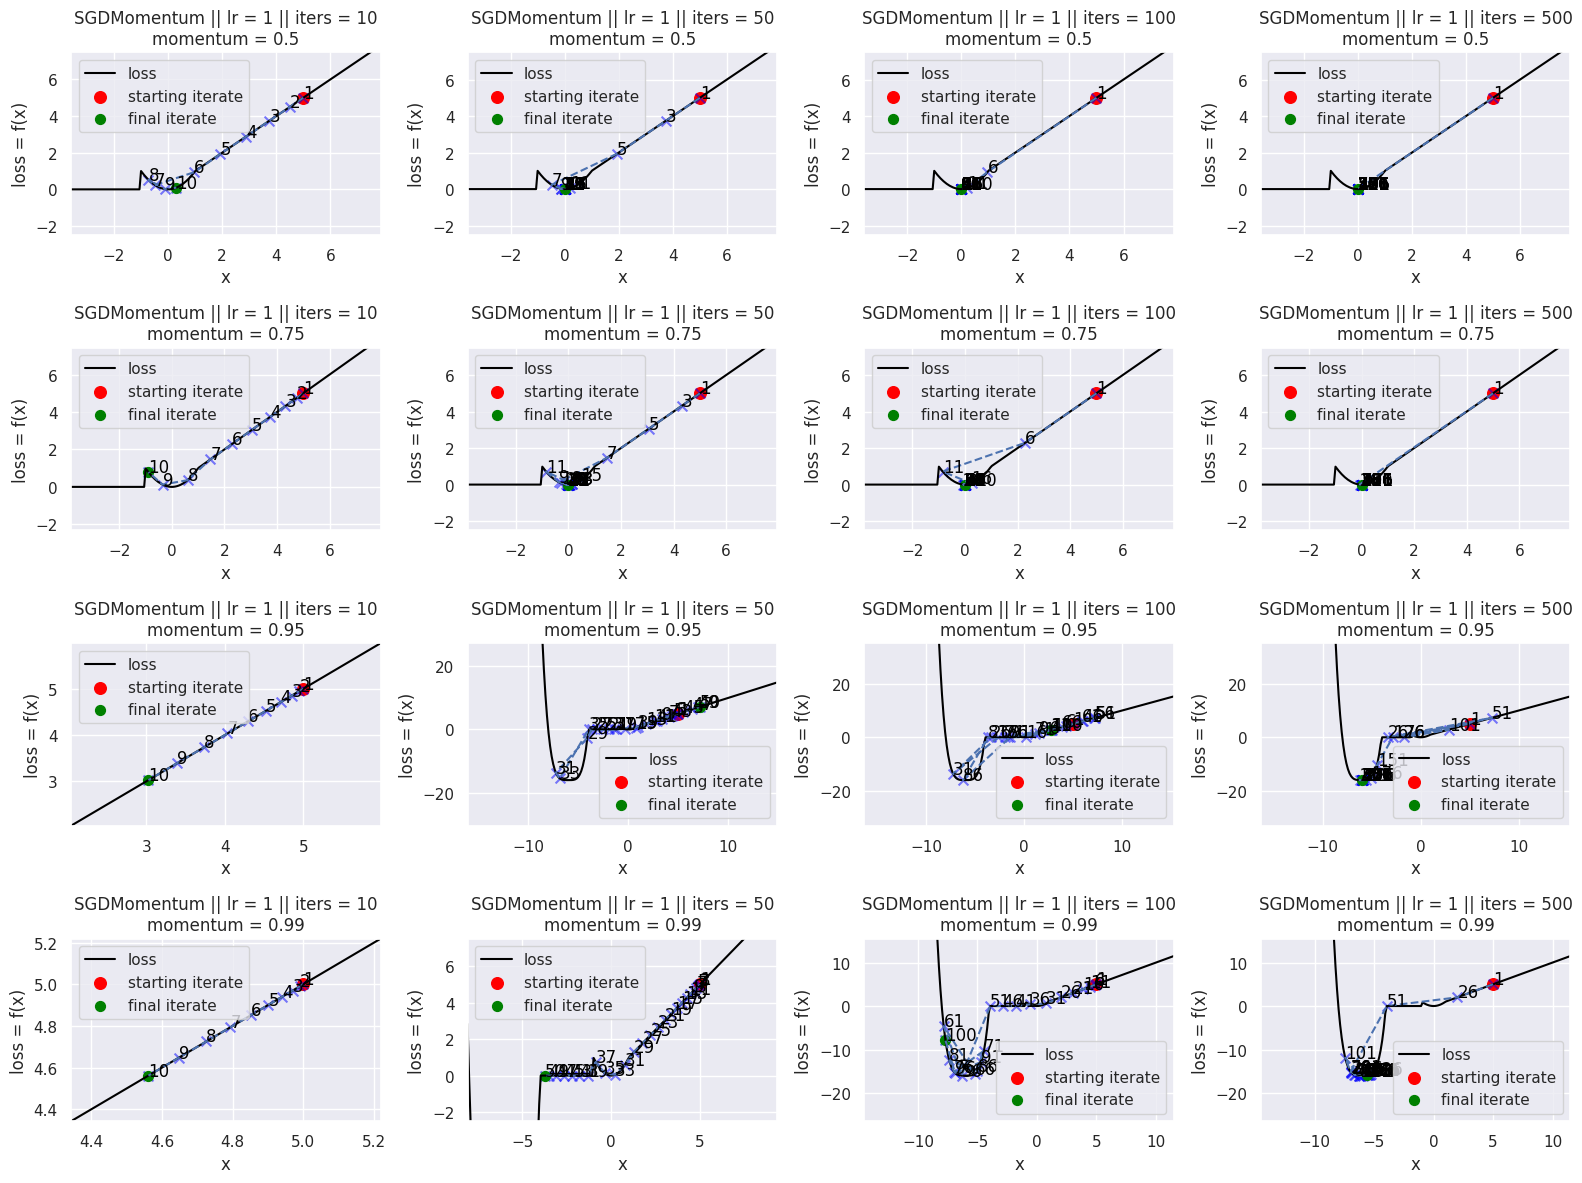

In [14]:
fig, axes_2d = plt.subplots(4,4,figsize=(4*4,3*4))
opt = SGDMomentum
lr = 1

for axes, m in zip(axes_2d, [0.5, 0.75, 0.95, 0.99]):
    for ax, iters in zip(axes, [10, 50, 100, 500]):
        plot_iterates_and_loss(init=5, optmizer=lambda p: SGDMomentum(params=p, lr=lr, momentum=m), num_iters=iters, max_points = 20, figsize=(4,3), ax=ax)
        ax.set_title(f'{opt.__name__} || lr = {lr} || iters = {iters}\nmomentum = {m}')

plt.tight_layout()
plt.show()

If the algorithm lands on a local minima, or, the iterate lands on a flat surface, then it depends on the momentum of the current iterate if it is able to and how fast (number of epochs) is it able to escape the local minima.

Also, there is another interesting thing to notice, in the second column, in plots 3 and 4 (from the top), it is clear that a faster momentum does not always necessarily imply a faster convergence. This is because, the velocity (mevement from last iterate to current) of the recent iterates has more weightage than the velocity of the earlier ones and the sequence of iterates (on which the current velocity depends) is different for both the plots

Let's try to observe how sensitive SGD Momentum is to increasing the learning rate

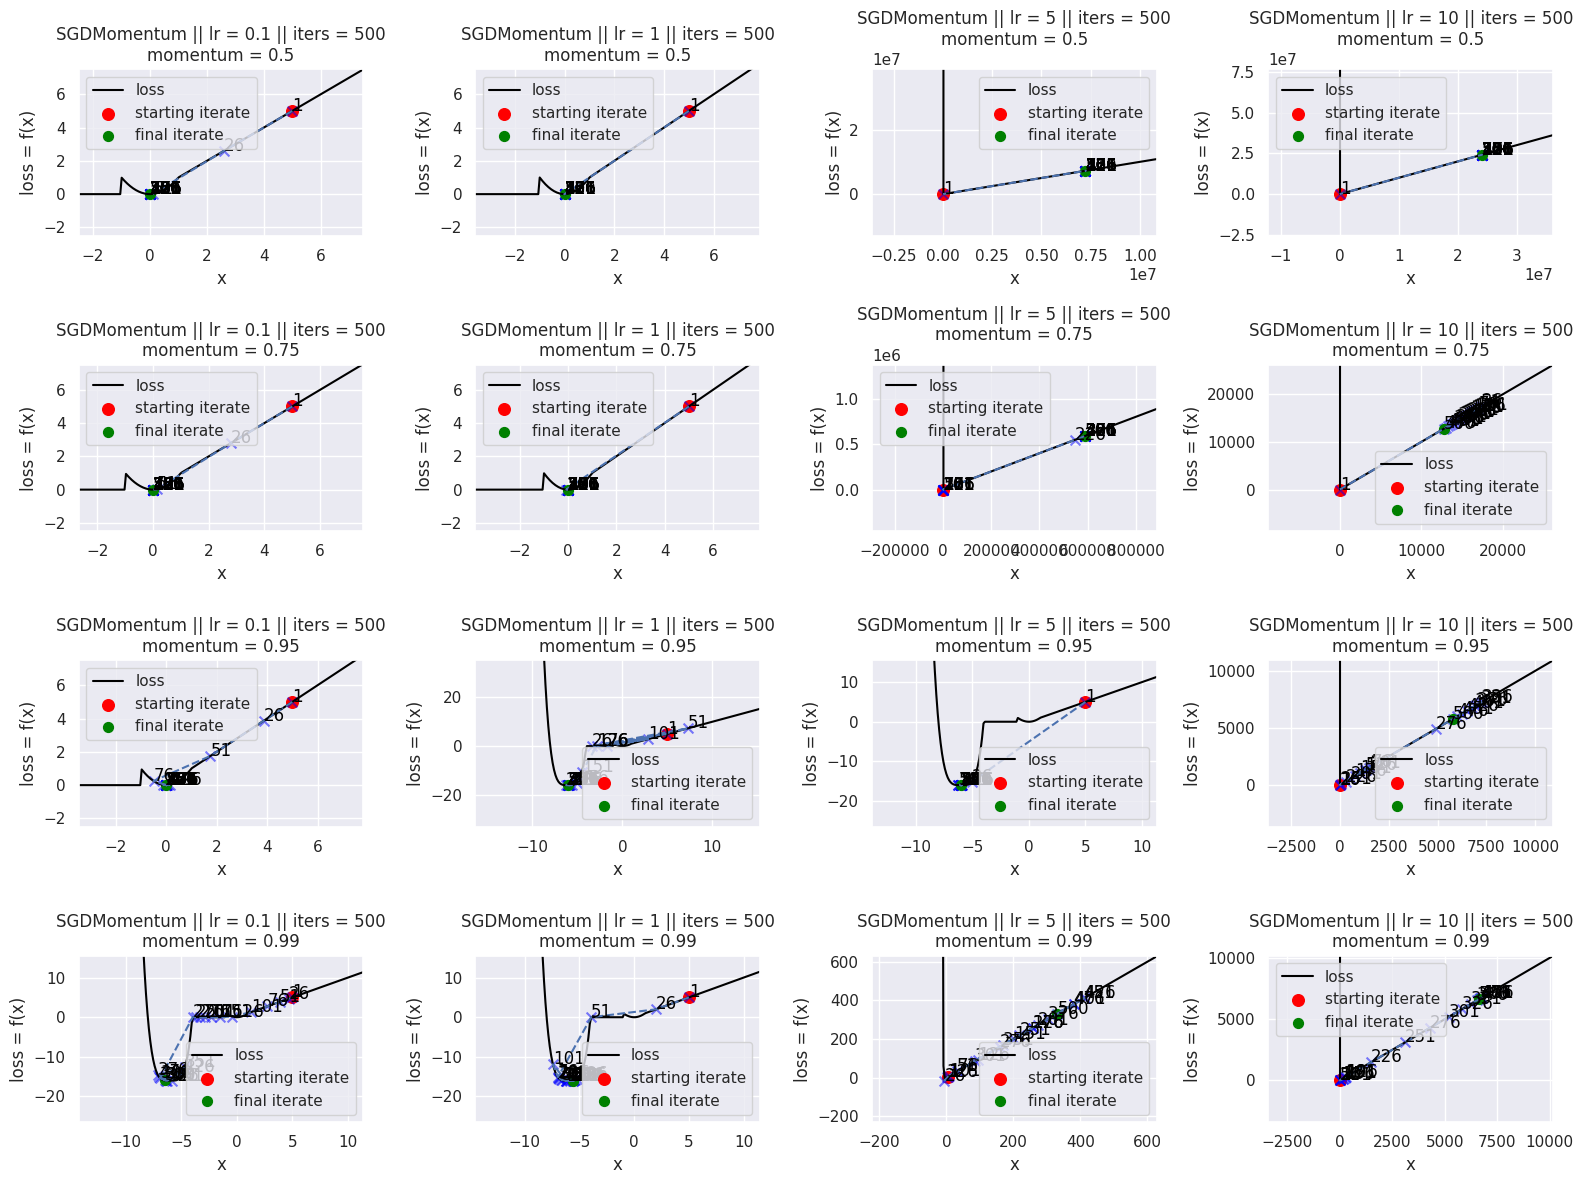

In [15]:
fig, axes_2d = plt.subplots(4,4,figsize=(4*4,3*4))
opt = SGDMomentum
iters = 500

for axes, m in zip(axes_2d, [0.5, 0.75, 0.95, 0.99]):
    for ax, lr in zip(axes, [0.1, 1, 5, 10]):
        plot_iterates_and_loss(init=5, optmizer=lambda p: SGDMomentum(params=p, lr=lr, momentum=m), num_iters=iters, max_points = 20, figsize=(4,3), ax=ax)
        ax.set_title(f'{opt.__name__} || lr = {lr} || iters = {iters}\nmomentum = {m}')

plt.tight_layout()
plt.show()

As we increase the learning rate, the iterate can escape the minimas to land in a region where the loss is very high

Another interesting insight is present in the third column in the plots 2, 3 and 4 from the top. On comparing plots 2 and 3, it looks like increasing the momentum makes the iterate escape the behaviour described above, but comparing plots 3 and 4, this assumption is violated. Essentially, lr and momentum are the two parameters that will have to be tuned for this optimizer

Let's see what happens when we start from a local minima

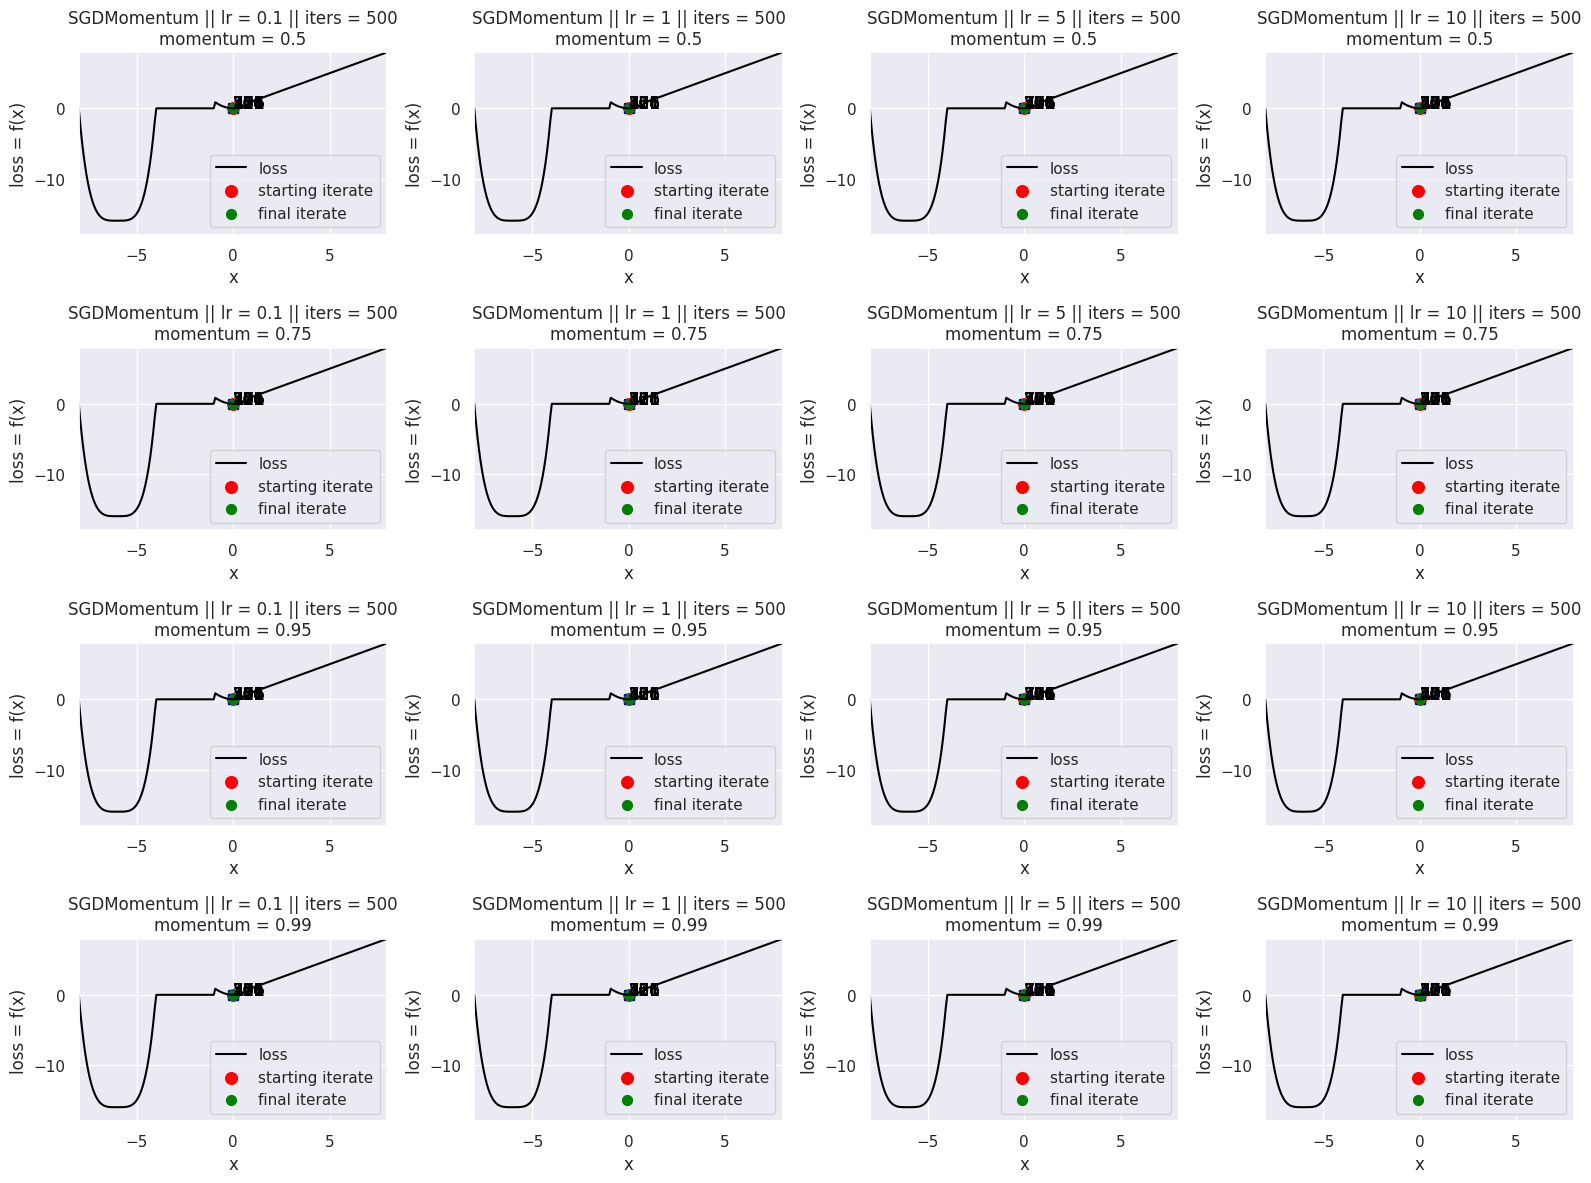

In [16]:
fig, axes_2d = plt.subplots(4,4,figsize=(4*4,3*4))
opt = SGDMomentum
iters = 500

for axes, m in zip(axes_2d, [0.5, 0.75, 0.95, 0.99]):
    for ax, lr in zip(axes, [0.1, 1, 5, 10]):
        plot_iterates_and_loss(init=0, optmizer=lambda p: SGDMomentum(params=p, lr=lr, momentum=m), num_iters=iters, max_points = 20, figsize=(4,3), ax=ax,
                               xlim=(-8,8), ylim=(-18, 8))
        ax.set_title(f'{opt.__name__} || lr = {lr} || iters = {iters}\nmomentum = {m}')

plt.tight_layout()
plt.show()

As expected, no change in parameters can make the iterate escape from the local minima. This is because the initial velocity is zero and the subsequent velocity also becomes zero due to the zero gradient. This behaviour will also be observed if the initial iterate is present on a flat surface

Let's observe the rate of convergence if the initial iterate is near a global minima

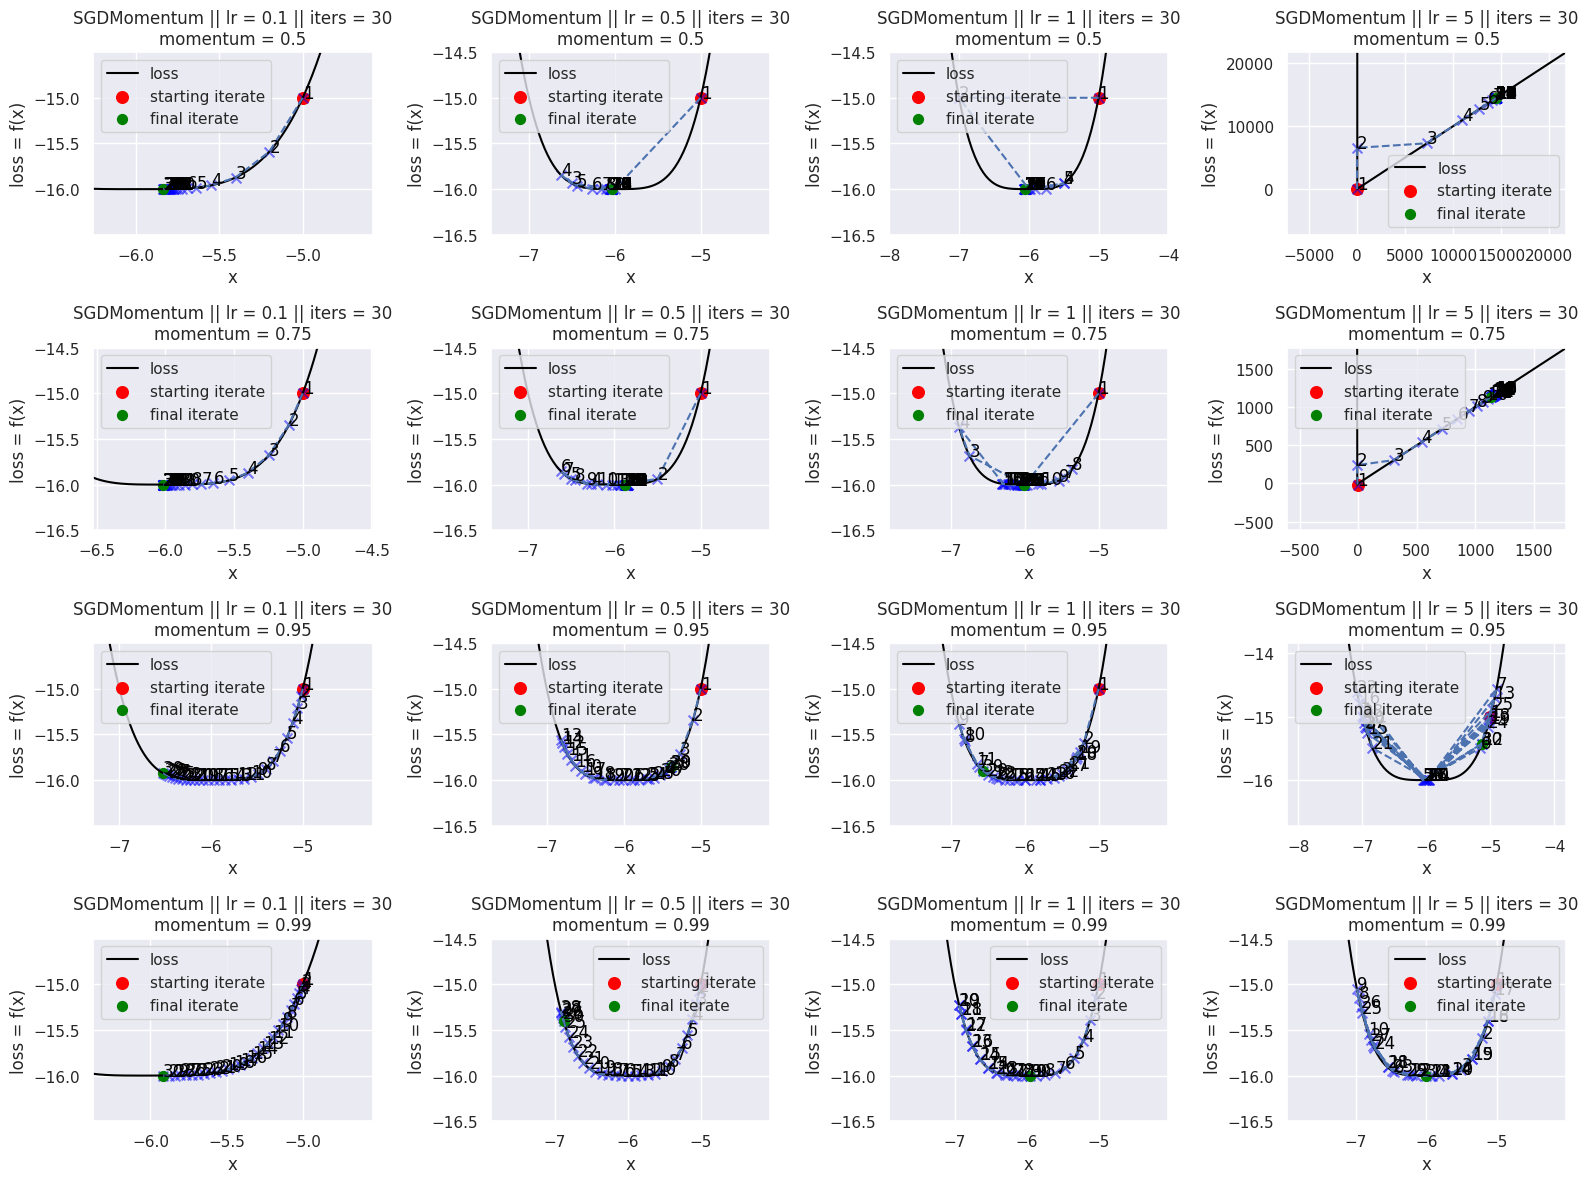

In [17]:
fig, axes_2d = plt.subplots(4,4,figsize=(4*4,3*4))
opt = SGDMomentum
iters = 30

for axes, m in zip(axes_2d, [0.5, 0.75, 0.95, 0.99]):
    for ax, lr in zip(axes, [0.1, 0.5, 1, 5]):
        plot_iterates_and_loss(init=-5, optmizer=lambda p: SGDMomentum(params=p, lr=lr, momentum=m), num_iters=iters, max_points = 20, figsize=(4,3), ax=ax)
        ax.set_title(f'{opt.__name__} || lr = {lr} || iters = {iters}\nmomentum = {m}')

plt.tight_layout()
plt.show()

It is clear that SGD momentum does bounce around too much (even for large learning rates) as compared to the vanilla SGD, which implies faster convergence

### FINDINGS

1. has the capacity to escape the local minima or flat surfaces given that the initial iterate is not on a local minima or a flat surface
2. sensitive to large learning rates
3. faster convrgence as compared to SGD